Epoch [1/50] Train Loss: 0.4454, Val Loss: 0.2350 Train Acc: 0.8654, Val Acc: 0.9295
Epoch [2/50] Train Loss: 0.1932, Val Loss: 0.1506 Train Acc: 0.9418, Val Acc: 0.9541
Epoch [3/50] Train Loss: 0.1323, Val Loss: 0.1448 Train Acc: 0.9585, Val Acc: 0.9548
Epoch [4/50] Train Loss: 0.1055, Val Loss: 0.1065 Train Acc: 0.9674, Val Acc: 0.9686
Epoch [5/50] Train Loss: 0.0862, Val Loss: 0.0887 Train Acc: 0.9731, Val Acc: 0.9728
Epoch [6/50] Train Loss: 0.0783, Val Loss: 0.1142 Train Acc: 0.9752, Val Acc: 0.9639
Epoch [7/50] Train Loss: 0.0685, Val Loss: 0.0879 Train Acc: 0.9783, Val Acc: 0.9725
Epoch [8/50] Train Loss: 0.0598, Val Loss: 0.0761 Train Acc: 0.9812, Val Acc: 0.9765
Epoch [9/50] Train Loss: 0.0537, Val Loss: 0.0969 Train Acc: 0.9829, Val Acc: 0.9713
Epoch [10/50] Train Loss: 0.0516, Val Loss: 0.0870 Train Acc: 0.9829, Val Acc: 0.9751
Epoch [11/50] Train Loss: 0.0459, Val Loss: 0.0899 Train Acc: 0.9849, Val Acc: 0.9737
Epoch [12/50] Train Loss: 0.0391, Val Loss: 0.1036 Train Acc: 0

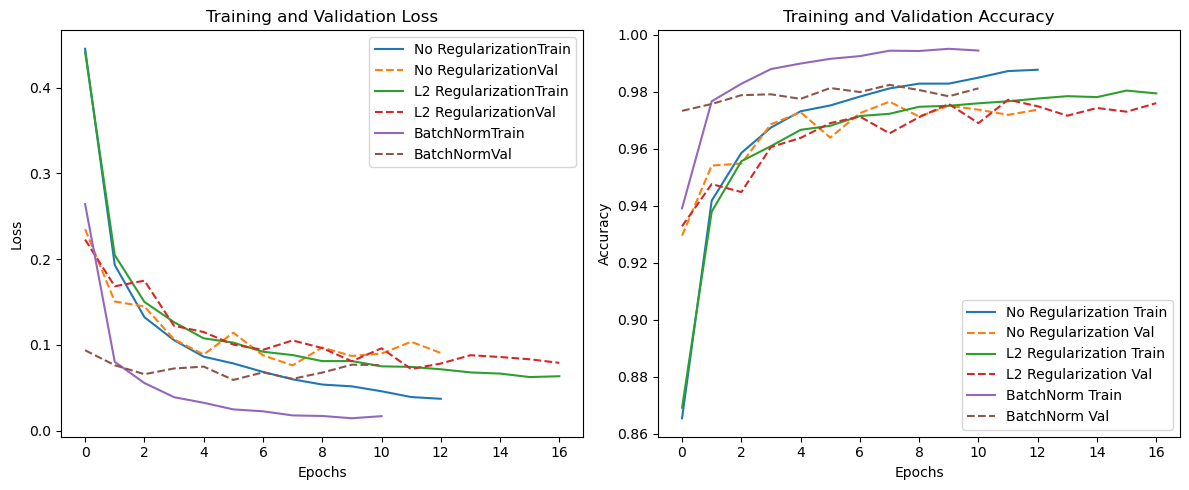

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy

# -----------------------------
# 1. Hyperparameters
# -----------------------------
batch_size = 128
learning_rate = 0.001
max_epochs = 50
patience = 5  # for early stopping
input_size = 28*28
hidden_sizes = [256, 128, 64]
output_size = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# 2. Data Loading
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 3. Neural Network Class
# -----------------------------
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size,
                 use_dropout=False, dropout_p=0.5,
                 use_batchnorm=False):
        super(FCNet, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(dropout_p))
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# -----------------------------
# 4. Training Function
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, max_epochs, patience):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(max_epochs):
        # --- Training ---
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # --- Validation ---
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # --- Early Stopping ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print(f"Epoch [{epoch+1}/{max_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} "
              f"Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

experiment_config=[
    {"name":"No Regularization","use_dropout":False,"use_batchnorm":False,"weight_decay":0},
    {"name":"L2 Regularization","use_dropout":False,"use_batchnorm":False,"weight_decay":0.001},
    {"name":"BatchNorm","use_dropout":False,"use_batchnorm":True,"weight_decay":0}
]

results={}
for config in experiment_config:
    model=FCNet(input_size,hidden_sizes,output_size,
                use_dropout=config["use_dropout"],
                use_batchnorm=config["use_batchnorm"]).to(device)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=config["weight_decay"])
    model,train_losses,val_losses,train_accs,val_accs=train_model(
        model,train_loader,val_loader,criterion,optimizer,max_epochs,patience
    )
    results[config["name"]]={
        "train_losses":train_losses,
        "val_losses":val_losses,
        "train_accs":train_accs,
        "val_accs":val_accs
    }

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name,res in results.items():
    plt.plot(res["train_losses"],label=name+"Train")
    plt.plot(res["val_losses"],'--',label=name+"Val")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
for name, res in results.items():
    plt.plot(res["train_accs"], label=name+" Train")
    plt.plot(res["val_accs"], '--', label=name+" Val")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
    
    